## Assignment 2: Model Analysis

As a reminder, here is the scenario from last time.

>  You are the head of the R&D department at Pie-thagoras Labs, a new FoodTech start-up that is aimed at helping members of the visually impaired and blind community in different food-related situations. The first products you are making are image-based dessert classifiers that enable users to obtain detailed information about foods in front of them by simply taking a picture.

In this assignment, you are going to be evaluating three different dessert classification models.  We are keeping the nature of the models and how most of the details about how they were trained a secret.  Instead, we want you to focus on making a determination about whether any of the three models are ready to be used by members of the blind community.  If so, what conditions would the models be suitable to be used in?


### Training Data

Each of the three models was trained on the same 18,400 images of desserts (800 images for each of 23 desserts). The models differ in how computationally expensive they are to run (model 1 is the fastest, model 2 is in the middle, and model 3 is the slowest), the details of how the training data was manipulated before being fed into the model, and the complexity of the model itself (model 1 is the simplest, model 2 is in the middle, and model 3 is the most complex).

### Model Testing

Along with each model, we have included the results of three test runs on each model (9 in total).  For testing, we ran each model with a set of 4600 images (200 images for each of the 23 dessert classifications that the models were trained on), yielding predictions for each inputted image.  The three test conditions were:

* **Test Condition 1:** Images were resized so the smallest dimension (width or height was 256 pixels).  A 224x224 image was then cropped from the center of the image.
* **Test Condition 2:** A random patch of the test image was cropped and then resized to 224x224 pixels.  Finally, with probability 1/2 the image was reflected across the vertical axis (mirroring the left and right side of the image).
* **Test Condition 3:** Each image was randomly rotated by an angle between -180 and +180 degrees.  Next, each image were resized so the smallest dimension (with or height was 256 pixels).  Next, a 224x224 image was then cropped from the center of the image.  Finally, with probabilty 1/2 the image was reflected across the vertical axis (mirroring the left and right side of the image).

These modifications might seem a bit confusing.  Never fear!  We're going to dive into how this all works next.

First, we'll clone some the base repository for this assignment, and download the training data.  We'll also execute a command to show you where the data is downloaded.

In [ ]:
!git clone https://github.com/olinml2024/machine_learning_a2

In [1]:
%cd machine_learning_a2
from data_utils import download_dessert_test_data
download_dessert_test_data()
!ls test_data/images

/home/ideluis42/ML/machine_learning_a2


Downloading...
From (original): https://drive.google.com/uc?id=1k_KaPCCO37HC8eqpd0D0JhKyGhqM8_KL
From (redirected): https://drive.google.com/uc?id=1k_KaPCCO37HC8eqpd0D0JhKyGhqM8_KL&confirm=t&uuid=2f5c5a0b-f84e-47ac-b3d6-1efba9554e4d
To: /home/ideluis42/ML/machine_learning_a2/test_data.zip
100%|██████████| 221M/221M [00:15<00:00, 14.4MB/s] 


apple_pie      cheesecake	 cup_cakes	pancakes
baklava        chocolate_cake	 donuts		red_velvet_cake
beignets       chocolate_mousse  french_toast	strawberry_shortcake
bread_pudding  churros		 frozen_yogurt	tiramisu
cannoli        creme_brulee	 ice_cream	waffles
carrot_cake    croque_madame	 macarons


Using the `Files` functionality of Colab, you can browse to the location where the test data has been downloaded and open any of the images you'd like.  To access apple pie images, for example, you would navigate to `machine_learning_a2` -> `test_data` -> `images` -> `apple_pie` and then click on the image you want to view.

We can also write some code to view sets of images.  There are quite a few ways to load and display these images, but we are going to make us of the `pytorch` library, since we will be using it a bunch later in the course.  Next, we'll show how to grab some images and display them.

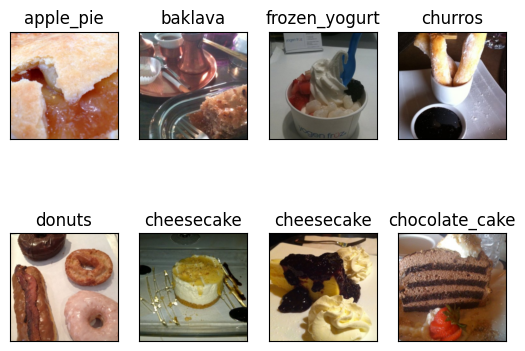

In [6]:
%matplotlib inline
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from model_testing.test import CLASS_INDICES_REVERSED
import numpy as np
import torch

def display_sample_images(image_transform):
    test_set = datasets.ImageFolder('test_data/images', image_transform)
    test_set_loader = DataLoader(test_set, batch_size=8, shuffle=True, num_workers=0)
    inputs, outputs = next(iter(test_set_loader))
    fig, axs = plt.subplots(nrows=2, ncols=4, squeeze=False)
    for i in range(inputs.shape[0]):
        img = inputs[i,:,:,:].squeeze().detach().numpy().transpose((1, 2, 0))
        ax = axs[i // 4, i % 4]
        ax.imshow(img)
        ax.set_title(f'{CLASS_INDICES_REVERSED[outputs[i].item()]}')
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()


# This line of code specifies how we the data should be processed (this is
# what was used for test scenario 1 as described earlier).  For details
# of each of these functions you can examine the torchvision documentation.
# https://pytorch.org/vision/stable/transforms.html
test_scenario_1 = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])
display_sample_images(test_scenario_1)

We can also specify the transforms used for test scenario 2.  Try running it a few times to get a sense of the variability.

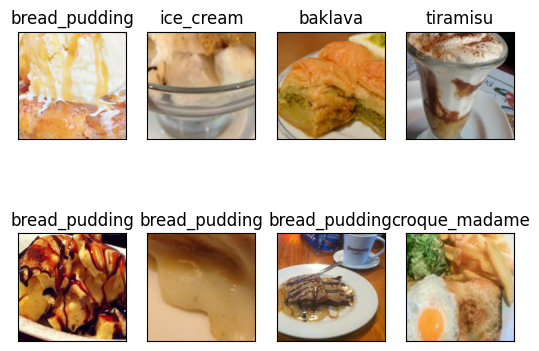

In [8]:
test_scenario_2 = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
display_sample_images(test_scenario_2)

Finally, we can specify the transforms used for test scenario 3.  As before, try running it a few times to get a sense of the variability.

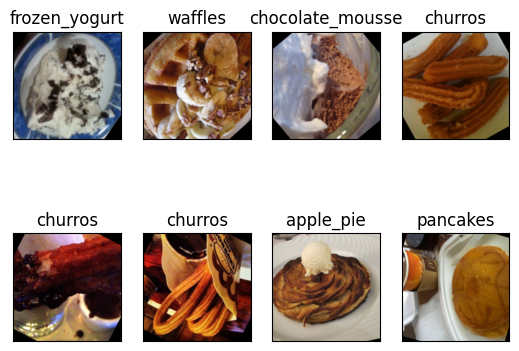

In [9]:
test_scenario_3 = transforms.Compose([transforms.RandomRotation(degrees=(-180, 180)),
                                      transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
display_sample_images(test_scenario_3)

Now that you've seen the various was in which the images can be transformed, you might want to think about what conditions the end user of your system would encounter if they were to use this in the real world.

Okay, let's load the predictions for each of our models.  Later in the notebook you can run the models yourself, but to make things faster, we've precomputed each model output for each of the three test scenarios.

The code below loads a dictionary with the following test runs.  The table shows ground truth labels / predicted labels for each combination.

| Model              | Test Condition 1 | Test Condition 2 | Test Condition 3 |
| :---------------- | :------: | ----: | ----: |
| Model 1        |   model1_test_1_gt / model1_test_1_preds  | model1_test_2_gt / model1_test_2_preds | model1_test_2_gt / model1_test_2_preds
| Model 2        |   model2_test_1_gt / model2_test_1_preds  | model2_test_2_gt / model2_test_2_preds | model2_test_2_gt / model2_test_2_preds
| Model 3        |   model3_test_1_gt / model3_test_1_preds  | model3_test_2_gt / model3_test_2_preds | model3_test_2_gt / model3_test_2_preds


In [10]:
import json

with open('cached_outputs.json') as f:
    model_outputs = json.load(f)

model_outputs.keys()

dict_keys(['model1_test_1_gt', 'model1_test_1_preds', 'model1_test_2_gt', 'model1_test_2_preds', 'model1_test_3_gt', 'model1_test_3_preds', 'model2_test_1_gt', 'model2_test_1_preds', 'model2_test_2_gt', 'model2_test_2_preds', 'model2_test_3_gt', 'model2_test_3_preds', 'model3_test_1_gt', 'model3_test_1_preds', 'model3_test_2_gt', 'model3_test_2_preds', 'model3_test_3_gt', 'model3_test_3_preds'])

In addition to these cached outputs, you can also run the models yourselves.  Next, we'll download all of the models and then run a model on an image from the web.

In [11]:
!pip install wget
from model_utils import load_models, get_model_preds, test_on_image
from PIL import Image
import wget

models = load_models()

Downloading...
From (original): https://drive.google.com/uc?id=1MQT3EyNmKPsLXRX8r39x8netudx2kBFt
From (redirected): https://drive.google.com/uc?id=1MQT3EyNmKPsLXRX8r39x8netudx2kBFt&confirm=t&uuid=859c1929-eb4f-4a6c-90d8-65a052db4102
To: /home/ideluis42/ML/machine_learning_a2/model0.pth
100%|██████████| 44.8M/44.8M [00:03<00:00, 12.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ideluis42/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.8MB/s]
/home/ideluis42/ML/machine_learning_a2/model_utils.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` wi

Next, we'll run the models on data from the web and from an image in the repo.  You can also upload more images to test on these as  well.

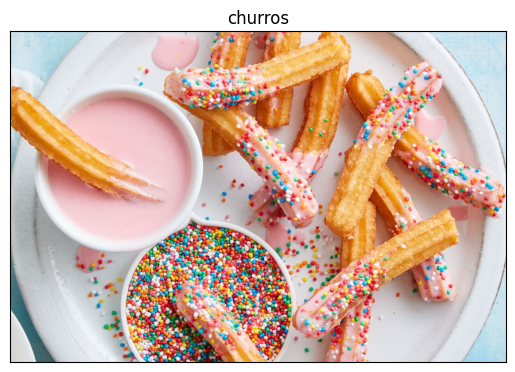

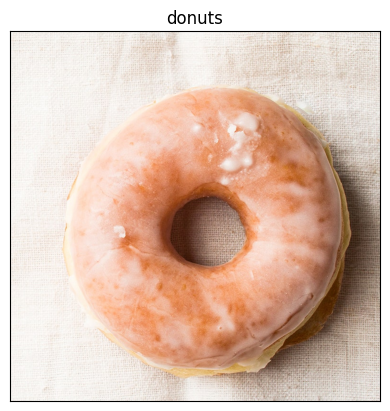

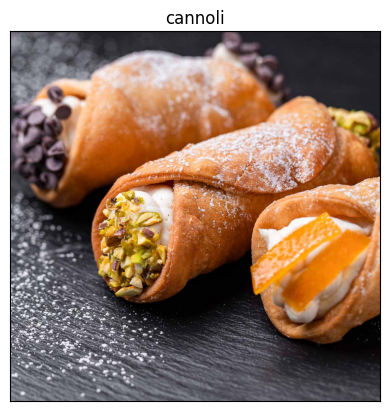

In [12]:
def test_web_image(model, url):
    file_name = wget.download(url)
    img = Image.open(file_name)
    output = test_on_image(model, img)

    plt.imshow(img)
    plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    if output is not None:
        plt.title(CLASS_INDICES_REVERSED[output])
    plt.show()

def test_on_local_image(model, image_path):
    img = Image.open(image_path)
    output = test_on_image(model, img)

    plt.imshow(img)
    plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    if output is not None:
        plt.title(CLASS_INDICES_REVERSED[output])
    plt.show()

test_web_image(models[0], 'https://img.taste.com.au/FHudZ4_i/taste/2021/06/fairy-bread-churros-171749-2.jpg')
test_web_image(models[2], 'https://assets.epicurious.com/photos/54b0226d766062b20344580a/1:1/w_2240,c_limit/51160200_glazed-doughnuts_1x1.jpg')

test_on_local_image(models[1], 'images/cannoli-recipe-snippet.jpg')

Finally, if you want (and have patience), you can rerun the models on the entire 4,600 test images.  If you do this, we recommend you swith Colab to a GPU runtime so it doesn't take too long.  **Most folks will not need to run the following code blocks, so we'll collapse them for now**

In [13]:
#@title Code for running all models on all testing scenarios

test_condition_1 = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_condition_2 = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_condition_3 = transforms.Compose([
        transforms.RandomRotation(degrees=(-180, 180)),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_conditions = [test_condition_1, test_condition_2, test_condition_3]

outputs = {}

for idx, model in enumerate(models):
    for idx2, condition in enumerate(test_conditions):
        print(f"Evaluating model {idx+1} test condition {idx2+1}")
        model_gt, model_preds = get_model_preds(model, condition)
        outputs[f'model{idx+1}_test_{idx2+1}_gt'] = model_gt
        outputs[f'model{idx+1}_test_{idx2+1}_preds'] = model_preds

Evaluating model 1 test condition 1
96/4600
192/4600
288/4600
384/4600
480/4600
576/4600
672/4600
768/4600
864/4600
960/4600
1056/4600
1152/4600
1248/4600
1344/4600
1440/4600
1536/4600
1632/4600
1728/4600
1824/4600
1920/4600
2016/4600
2112/4600
2208/4600
2304/4600
2400/4600
2496/4600
2592/4600
2688/4600
2784/4600
2880/4600
2976/4600
3072/4600
3168/4600
3264/4600
3360/4600
3456/4600
3552/4600
3648/4600
3744/4600
3840/4600
3936/4600
4032/4600
4128/4600
4224/4600
4320/4600


KeyboardInterrupt: 

In [ ]:
#@title Code for downloading model outputs to the local machine (e.g, to add to Github)

# download the cached data if useful
from google.colab import files

outputs_converted_for_json = {}
for key, value in outputs.items():
    value_changed = list(map(int, value))
    outputs_converted_for_json[key] = value_changed

with open('cached_outputs.json', 'w') as f:
    json.dump(outputs_converted_for_json, f)

files.download('cached_outputs.json')

## Write-Up Requirements

Now, you are ready to begin your analysis of each model. In your write-up, be sure to include each of the following:
- Examine the test data.  What do you notice about it?  What conditions is it representative of (e.g., lighting, point of view, scale of the dessert relative to the rest of the image, etc.).
- Utilize the functions from Assignment 1 to explore different estimates of accuracy for each model and test condition. Include analysis on how the metrics are relevant in the context of the problem of an app for dessert classification.
- Evaluate the models on at least 10 images that are outside of the testing dataset (these could be images you take yourself and upload to Colab or they could be images from the web).  If you find an interesting test image, please feel free to share it with the class via Slack.
- For each model you believe is fit for production, include an assessment of the conditions under which the model is likely to perform well and when it would be expected to perform poorly.  Be sure to explain your analysis (how did you arrive at this conclusion).  You will likely have to make some assumptions about the context in which the model would be used (e.g., by folks who are blind).  In the interests of time, you may make some assumptions (rather than doing a lot of background research).  Make sure to note your assumptions though (and what lingering questions you have).
- For each model you believe is not fit for production, include an assessment of why you believe so.  Be sure to explain your analysis (how did you arrive at this conclusion).  In what ways should the models be improved to make them production ready?

Be sure to attach any code/resources you used to create your write-up.


Possible (optional) extensions:
-  Transform the testing data in different was to better understand each model's performance.  You may consider changing the brightness of each image to evaluate the dependence on lighting conditions or changing the resolution of each image to determine if a certain level of quality is necessary for the algorithms to be successful.  In order to do this, you'll want to check out the [torchvision transforms module documentation](https://pytorch.org/vision/stable/transforms.html).
- Benchmark the time it takes to run each model by modifying the given code that runs the model on the test set.